# Imports and functions

In [477]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from sklearn.metrics import balanced_accuracy_score

In [478]:
import torchvision
import engine
import helper_functions

In [479]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, f1_score
from collections import deque  # Import deque for early stopping
import warnings

# Suppress the specific UserWarning related to y_pred and y_true class mismatch
warnings.filterwarnings("ignore", category=UserWarning, message="y_pred contains classes not in y_true")

In [480]:
from sklearn.metrics import balanced_accuracy_score

# Function to calculate balanced accuracy using sklearn
def balanced_accuracy(y_true, y_pred):
    return balanced_accuracy_score(y_true, y_pred) * 100

In [481]:
# Function to perform one-hot encoding for DNA sequences
def one_hot_encode(sequence):
    encoding = {'A': [1, 0, 0, 0], 'T': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'C': [0, 0, 0, 1]}
    one_hot_sequence = [encoding.get(base, [0, 0, 0, 0]) for base in sequence]
    return np.array(one_hot_sequence)

# Set up device agnostic code

In [482]:
import torch
from torch import nn
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [483]:
# Define Name of TF 
tf="RELA"
file_path = f'/mnt/raid1/thalassini/home/filtered_fimo(>3)/{tf.upper()}/datasets/data.csv'
df = pd.read_csv(file_path)
df

,data,class
0,AGCAACTATTGTCAGCCCATCTCAAGCCAGAGTGTCTCCCCAGAAC...,0
1,GATGAGTGTGTCTGTGTGTCTGTCTCTCTCCGCATGTGCACACGGG...,0
2,TCATCCCCACCAAGAGCTTACTGTGACTGAGAGTTACGCAGCCCGA...,0
3,GGAAATTCAAGATGTTTCATAAATCATCCACTTCAGTAATTGATCT...,0
4,AGCTTCTCACCCTCTGATCTTTGCCATTGAGTCCCCTGTGTCCTCT...,0
...,...,...
56082,ACTCCCCTTCCCCAACTTACACACACTCACACACACACATACACAC...,1
56083,AATTTCCCCTTTCTTCTTTGTTTCGGTGTCAATTTTTTTTTTAGTT...,1
56084,CTTATTATTATTTAGAGAGCTGGGAACTGGTTAAACTTTAAAAAAT...,1
56085,AAATGAATGAACTGCAAATTTGAATAGGGTGAACTTTATGATACAT...,1


# Sequence length inspection and normalization

Max length:209, Min length: 201


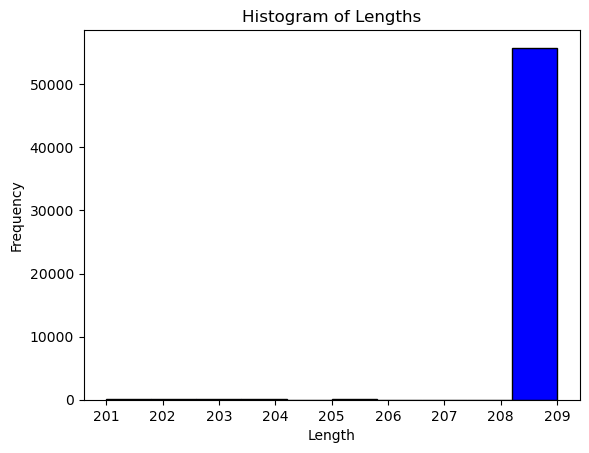

In [484]:
lengths= [len(item) for item in df['data']] 
print(f'Max length:{max(lengths)}, Min length: {min(lengths)}')
import matplotlib.pyplot as plt
# Plotting the histogram
plt.hist(lengths, bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [485]:
# Find the maximum length of sequences
#min_length = min(len(seq) for seq in df['data'])
limit=200


# Pad or cut sequences to ensure they all have the same length
cut_sequences = [seq[:limit] for seq in df['data']]

# Update the DataFrame with the cut sequences
#df['data'] = cut_sequences

In [486]:
lengths= [len(item) for item in cut_sequences]
print(f'Max length:{max(lengths)}, Min length: {min(lengths)}')

Max length:200, Min length: 200


# Define X,y variables

In [487]:
X=[one_hot_encode(sequence) for sequence in cut_sequences]

In [488]:
X = torch.from_numpy(np.array(X)).type(torch.float)


In [489]:
X.shape

torch.Size([56087, 200, 4])

In [490]:
y=np.array(df['class'])
y[:3]

array([0, 0, 0])

In [491]:
y = torch.from_numpy(y).type(torch.float)

# Split the data in train, val and test set

In [492]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit



# Split the data into a stratified hold-out validation set and the rest
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_val_index, test_index in stratified_splitter.split(X, y):
    X_train_val, X_test = X[train_val_index], X[test_index]
    y_train_val, y_test = y[train_val_index], y[test_index]

# Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)

print(len(X_train), len(y_train), len(X_val), len(y_val))
print(len(X_test), len(y_test))


# (X_train, X_val, y_train, y_val) for training, validation
# X_test, y_test for the final hold-out validation.

#X_train, X_val, X_test = torch.from_numpy(X_train).type(torch.float),torch.from_numpy(X_val).type(torch.float), torch.from_numpy(X_test).type(torch.float)



35895 35895 8974 8974
11218 11218


# Create datasets and Dataloaders

In [493]:
from torch.utils.data import DataLoader, TensorDataset
torch.manual_seed(42)


# Expand the dimensions of y to make it 2-dimensional
y_train = y_train.view(-1, 1)
y_test = y_test.view(-1,1)
y_val = y_val.view(-1,1)
# Concatenate the complement of y to create a 2-dimensional tensor
y_train_one_hot = torch.cat([1 - y_train, y_train], dim=1).float()
y_test_one_hot = torch.cat([1 - y_test, y_test], dim=1).float()
y_val_one_hot = torch.cat([1 - y_val, y_val], dim=1).float()


# Move tensors to the same device
X_train, y_train_one_hot, y_train = X_train.to(device), y_train_one_hot.to(device), y_train.to(device)
X_val, y_val_one_hot, y_val = X_val.to(device), y_val_one_hot.to(device), y_val.to(device)
X_test, y_test_one_hot, y_test = X_test.to(device), y_test_one_hot.to(device), y_test.to(device)


print(X_train.size(0), y_train_one_hot.size(0), y_train.size(0))

# Create datasets
train_dataset = TensorDataset(X_train, y_train_one_hot, y_train)
val_dataset = TensorDataset(X_val, y_val_one_hot, y_val)
test_dataset = TensorDataset(X_test, y_test_one_hot, y_test)



35895 35895 35895


In [494]:

batch_size=64
torch.manual_seed(42)

# Convert to PyTorch DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Construct a 1 layer CNN with Maxpooling and Dropout

In [505]:
class Conv_v0(torch.nn.Module):

    def __init__(self):
        super(Conv_v0, self).__init__()

        self.conv1 = torch.nn.Conv1d(in_channels=4, out_channels=3, kernel_size=10)
        self.activation = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool1d(kernel_size=5)
        
        self.dropout = torch.nn.Dropout(p=0.5) 
        self.fc = torch.nn.Linear(in_features=114, out_features=2)
        #elf.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x= x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.activation(x)
        x = self.maxpool(x)
        
        # Reshape the output of the max pooling layer before passing it to the fully connected layer
        x = x.view(x.size(0), -1)
        
        #print("Size after reshaping:", x.size())
        x=self.dropout(x)
        x = self.fc(x)
       #x = self.sigmoid(x)
        return x


# Computing class weights

In [506]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight

# Assuming we have defined dataset
# train_dataset = TensorDataset(X_train, y_train_one_hot, y_train)

# Extract the labels from the dataset
_, _, y_train = zip(*train_dataset)

# Count occurrences of each class
class_0_count = sum(1 for label in y_train if label == 0)
class_1_count = sum(1 for label in y_train if label == 1)

# Total length of y_train
total_samples = len(y_train)

# Calculate class weights
weights = [total_samples / class_0_count, total_samples / class_1_count]

# Print the list of class weights
print("Class Weights List:", weights)




Class Weights List: [2.412298387096774, 1.7080656673804426]


# Set up loss function and optimizer

In [507]:
from torch.optim import lr_scheduler
weights = torch.tensor(weights).to(device)
#print(weights)

In [508]:
torch.manual_seed(42)

# Initialize model instance
model = Conv_v0()

# define the CrossEntropyLoss with weights
loss_fn = nn.BCEWithLogitsLoss(weight=weights)

# Define oprimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Define exponetntial lr with lr_scheduler
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.01)

In [509]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model(X_test.to(device))[:5]
y_logits

tensor([[-0.1080, -0.4991],
        [-0.1028, -0.4214],
        [ 0.1576, -0.2359],
        [ 0.1838, -0.2496],
        [-0.0382, -0.3235]], grad_fn=<SliceBackward0>)

In [510]:
results, _ = engine.train_with_early_stopping(model=model,
                                                  train_dataloader=train_loader,
                                                  valid_dataloader=val_loader,
                                                  optimizer=optimizer,
                                                  loss_fn=loss_fn,
                                                  epochs=100,
                                                  device=device)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4241 | train_bal_acc: 0.4966 | train_mcc: -0.0068 | valid_loss: 1.4039 | valid_bal_acc: 0.5000 | valid_mcc: 0.0000
Epoch: 2 | train_loss: 1.4073 | train_bal_acc: 0.4994 | train_mcc: 0.0015 | valid_loss: 1.3980 | valid_bal_acc: 0.5000 | valid_mcc: 0.0000
Epoch: 3 | train_loss: 1.4005 | train_bal_acc: 0.5002 | train_mcc: 0.0002 | valid_loss: 1.3923 | valid_bal_acc: 0.5000 | valid_mcc: 0.0000
Epoch: 4 | train_loss: 1.3919 | train_bal_acc: 0.5003 | train_mcc: 0.0018 | valid_loss: 1.3846 | valid_bal_acc: 0.5000 | valid_mcc: 0.0000
Epoch: 5 | train_loss: 1.3818 | train_bal_acc: 0.5007 | train_mcc: 0.0056 | valid_loss: 1.3731 | valid_bal_acc: 0.5001 | valid_mcc: 0.0006
Epoch: 6 | train_loss: 1.3685 | train_bal_acc: 0.5127 | train_mcc: 0.0465 | valid_loss: 1.3607 | valid_bal_acc: 0.5096 | valid_mcc: 0.0412
Epoch: 7 | train_loss: 1.3563 | train_bal_acc: 0.5367 | train_mcc: 0.0957 | valid_loss: 1.3533 | valid_bal_acc: 0.5277 | valid_mcc: 0.0754
Epoch: 8 | train_loss: 1.3

Epoch: 60 | train_loss: 1.2960 | train_bal_acc: 0.5658 | train_mcc: 0.1373 | valid_loss: 1.2960 | valid_bal_acc: 0.5676 | valid_mcc: 0.1458
Epoch: 61 | train_loss: 1.2982 | train_bal_acc: 0.5701 | train_mcc: 0.1448 | valid_loss: 1.2961 | valid_bal_acc: 0.5659 | valid_mcc: 0.1407
Epoch: 62 | train_loss: 1.2955 | train_bal_acc: 0.5684 | train_mcc: 0.1415 | valid_loss: 1.2970 | valid_bal_acc: 0.5668 | valid_mcc: 0.1420
Epoch: 63 | train_loss: 1.2957 | train_bal_acc: 0.5663 | train_mcc: 0.1377 | valid_loss: 1.2955 | valid_bal_acc: 0.5715 | valid_mcc: 0.1496
Epoch: 64 | train_loss: 1.2958 | train_bal_acc: 0.5691 | train_mcc: 0.1431 | valid_loss: 1.2951 | valid_bal_acc: 0.5622 | valid_mcc: 0.1373
Epoch: 65 | train_loss: 1.2959 | train_bal_acc: 0.5668 | train_mcc: 0.1382 | valid_loss: 1.2954 | valid_bal_acc: 0.5609 | valid_mcc: 0.1353
Epoch: 66 | train_loss: 1.2951 | train_bal_acc: 0.5677 | train_mcc: 0.1412 | valid_loss: 1.2957 | valid_bal_acc: 0.5705 | valid_mcc: 0.1488
Epoch: 67 | train_lo

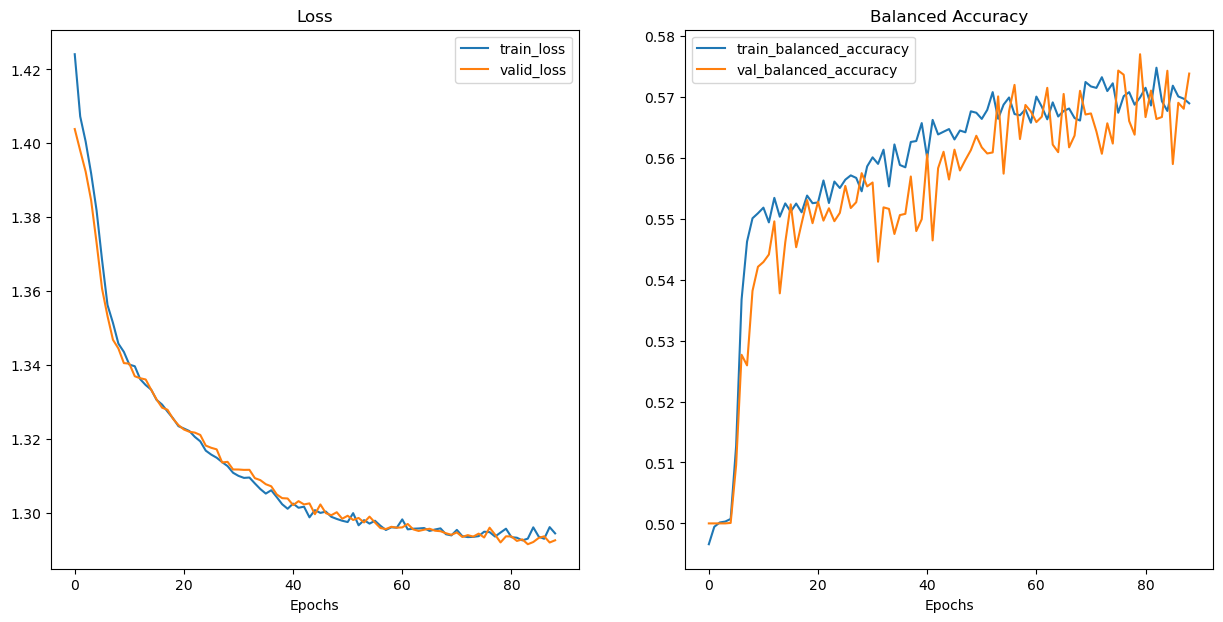

In [513]:
helper_functions.plot_loss_curves(results)
plt.savefig(f'{tf}_CNN1_ADAM_BCEWithLogits_KERNEL=10.png')

In [502]:
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, f1_score
import torch.nn.functional as F


model.eval()


with torch.inference_mode():
    all_predictions = []
    all_true_labels = []
    all_test_pred_prob=[]
    
    test_loss, test_bal_acc, test_mcc, test_f_score = 0, 0, 0, 0
    for batch, (X, y_one_hot, y) in enumerate(test_loader):
        # Send data to target device
        X, y_one_hot, y = X.to(device),y_one_hot.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model(X)

        # 2. Calculate and accumulate loss
        loss = loss_fn(test_pred_logits, y_one_hot)
        test_loss += loss.item()

        # Calculate and accumulate scores
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_pred_prob = torch.softmax(test_pred_logits.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)
        test_bal_acc += balanced_accuracy_score(y.cpu().numpy(), test_pred_labels.cpu().numpy())
        test_mcc += matthews_corrcoef(y.cpu().numpy(), test_pred_labels.cpu().numpy())
        test_f_score += f1_score(y.cpu().numpy(), test_pred_labels.cpu().numpy(), average='weighted')
        
        all_predictions.extend(test_pred_labels.cpu().numpy())
        all_true_labels.extend(y.cpu().numpy())
        all_test_pred_prob.extend(test_pred_prob.cpu().numpy())

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(test_loader)
    test_bal_acc = test_bal_acc / len(test_loader)
    test_mcc = test_mcc / len(test_loader)
    test_f_score = test_f_score / len(test_loader)
    print("Perfomance on held out test set")
    print(f'Test loss: {test_loss} | Test bal acc {test_bal_acc} | Test mcc {test_mcc} | Test_f_score {test_f_score}\n')   
    

Perfomance on held out test set
Test loss: 1.2990714223547415 | Test bal acc 0.5467266463967236 | Test mcc 0.10536644029570005 | Test_f_score 0.5632016967110546



In [503]:
from torch.utils.tensorboard import SummaryWriter
# Create a writer with all default settings
writer = SummaryWriter()